In [69]:
from collections import defaultdict
from typing import List, Tuple

import imageio.v2 as imageio
import numpy as np
import numpy.typing as npt
import random
import os


In [70]:
# Calculate error
def rmse(ref, gen):
    m, n = gen.shape
    subtracted_image = gen.astype(float) - ref.astype(float)
    squared_image = np.square(subtracted_image)
    mean_image = squared_image / (n * m)
    err = np.sum(mean_image)

    return np.sqrt(err)

def root_mean_sq_err(ref_image, gen_image):
    _, _, c = gen_image.shape
    if c == 1:
        return rmse(ref_image, np.squeeze(gen_image))
    else:
        err = [rmse(ref_image[:, :, i], gen_image[:, :, i]) for i in range(c)]
        return np.mean(err)


In [71]:
def distance(
    features: npt.NDArray[np.float32], centroid: npt.NDArray[np.float32]
) -> float:
    return np.sqrt(np.sum(np.power(features - centroid, 2), axis=1))


In [72]:
def init_centroids(features, seed, M, N, k):
    random.seed(seed)
    ids = np.sort(random.sample(range(0, M * N), k))
    centroids = np.array(features[ids])
    return centroids


In [73]:
def k_means(
    features: npt.NDArray[np.float32],
    k: int,
    n: int,
    M: int,
    N: int,
    seed: int,
) -> List[int]:
    centroids = init_centroids(features, seed, M, N, k)
    clusters = np.zeros(features.shape[0], dtype=np.float32)

    for _ in range(n):
        distances = np.zeros((features.shape[0], k), dtype=np.float32)
        for cluster in range(k):
            centroid = np.full(features.shape, centroids[cluster])
            dist = distance(features, centroid)
            distances[:, cluster] = dist

        clusters = np.argmin(distances, axis=1)
        for cluster in range(k):
            centroids[cluster] = np.mean(
                features[np.where(clusters == cluster)], axis=0
            )
    return centroids, clusters


In [74]:
def create_XY_features(M, N):
    X = np.tile(np.reshape(np.arange(M), (M, 1)), (1, N))
    Y = np.tile(np.reshape(np.arange(N), (N, 1)), (M, 1))
    X = np.reshape(X, (M * N, 1))
    Y = np.reshape(Y, (M * N, 1))
    XY = np.concatenate((X, Y), axis=1)
    return XY


def lum_reshape(image, M, N):
    return np.reshape(
        (0.299 * image[:, :, 0]) + (0.587 * image[:, :, 1]) + (0.114 * image[:, :, 2]),
        (M * N, 1),
    )


In [75]:
def _normalize_image(image):
    image = (image - image.min()) / (image.max() - image.min())
    image *= 255.0
    return image


def normalize_image(image):
    _, _, channels = image.shape
    if channels == 3:
        for channel in range(channels):
            image[:, :, channel] = _normalize_image(image[:, :, channel])
    else:
        image = _normalize_image(image)

    return image


def rgb_image_from(
    centroids: List[npt.NDArray[np.float32]],
    clusters: List[int],
    k: int,
    img_shape: Tuple,
):
    out_image = centroids[clusters % k][:, :3]
    out_image = np.reshape(out_image, img_shape)
    out_image = normalize_image(out_image)
    return out_image


def gray_image_from(
    centroids: List[npt.NDArray[np.float32]],
    clusters: List[int],
    k: int,
    img_shape: Tuple,
):
    out_image = centroids[clusters % k][:, 0]
    out_image = np.reshape(out_image, img_shape)
    out_image = normalize_image(out_image)
    return out_image


In [76]:
BASE_PATH = '../tests/resources/TestCases-InputImages'
image_filename = os.path.join(BASE_PATH, 'image_1.png')
ref_image_filename = os.path.join(BASE_PATH, 'image_1_ref3.png')
attributes_type = 3
k = 15
n = 10
seed = 190 #nice

image = imageio.imread(image_filename).astype(np.float32)
ref_image = imageio.imread(ref_image_filename).astype(np.float32)

M, N, _ = image.shape

match attributes_type:
    case 1:
        features = np.reshape(image, (M*N, 3))
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = rgb_image_from(centroids, clusters, k, (M, N, 3))
    case 2:
        XY = create_XY_features(M, N)
        features = np.reshape(image, (M*N, 3))
        features = np.concatenate((features, XY), axis=1)
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = rgb_image_from(centroids, clusters, k, (M, N, 3))
    case 3:
        features = lum_reshape(image, M, N)
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = gray_image_from(centroids, clusters, k, (M, N, 1))
    case 4:
        features = lum_reshape(image, M, N)
        features = np.concatenate((features, create_XY_features(M, N)), axis=1)
        centroids, clusters = k_means(features, k, n, M, N, seed)
        out_image = gray_image_from(centroids, clusters, k, (M, N, 1))
    case _:
        exit(1)

rmse = root_mean_sq_err(ref_image, out_image)
print(rmse)


0.5092147034511845


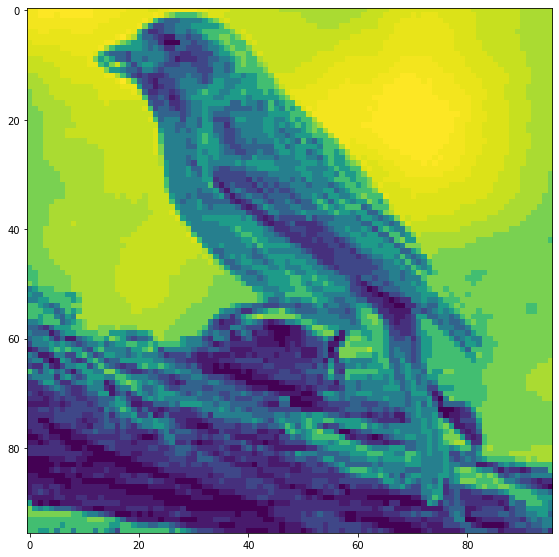

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 32))
plt.subplot(131)
plt.imshow(out_image.astype(np.uint8), vmin=0, vmax=255)

In [78]:
out_image.shape


(96, 96, 1)